In [1]:
# TODO 1: enumerative pose estimation
# 1) Just enumerate over all rotations and see fit
# 2) Record time and accuracy

# TODO 2: template-driven pose (rotation) estim experiment on single frame
# 1) Identify broad "(any) object" template (i.e. bounding box)
# 2) Quickly estimate object axis alignment from templates within bounding box (e.g. corner-to-corner distance/angle)
    # for the square example, easy corner detection is finding top/bottom x,y coords where color exists; from there can do simple geometric calcs
# 3) enumerate over the top n (small number n compared to all enums) poses close to the alignment calculated in Step 2 
    # this is roughly analogous to a proposal distributio
# 4) Record time and accuracy, especially compared to the naive enumerations

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
from fast_3dp3.model import make_scoring_function
from fast_3dp3.rendering import render_cloud_at_pose, render_planes
from fast_3dp3.utils import make_centered_grid_enumeration_3d_points, make_cube_point_cloud, quaternion_to_rotation_matrix
import time
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.transform import Rotation as R

import genjax

In [3]:
console = genjax.go_pretty()

In [4]:
h, w, fx_fy, cx_cy = (
    120,
    160,
    jnp.array([200.0, 200.0]),
    jnp.array([80.0, 60.0]),
)
r = 0.1
outlier_prob = 0.01

num_frames = 50


In [5]:
#  Establish gt poses (6 planes of a cube)

cube_plane_poses = jnp.array(
    [
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.5],
            [0.0, 0.0, 0.0, 1.0],
        ],
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, -0.5],
            [0.0, 0.0, 0.0, 1.0],
        ],
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, 0.5],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, -0.5],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        [
            [0.0, 0.0, 1.0, 0.5],
            [0.0, 1.0, 0.0, 0.0],
            [-1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        [
            [0.0, 0.0, 1.0, -0.5],
            [0.0, 1.0, 0.0, 0.0],
            [-1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
    ]
)

plane_dimensions = jnp.array(
    [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]
)
shape = (cube_plane_poses, plane_dimensions)
print(cube_plane_poses.shape)

gt_poses = [
    jnp.array(
        [
            [1.0, 0.0, 0.0, -1.0],
            [0.0, 1.0, 0.0, -1.0],
            [0.0, 0.0, 1.0, 5.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
]

delta_pose = jnp.array(
    [
        [1.0, 0.0, 0.0, 0.05],
        [0.0, 1.0, 0.0, 0.08],
        [0.0, 0.0, 1.0, 0.19],
        [0.0, 0.0, 0.0, 1.0],
    ]
)
delta_pose = delta_pose.at[:3, :3].set(
    jnp.array(R.from_euler("xy", [np.pi / 100, np.pi / 50]).as_matrix())
)


for t in range(num_frames):
    gt_poses.append(gt_poses[-1].dot(delta_pose))


(6, 4, 4)


In [6]:
# render GT images from gt poses

def render_planes_lambda(pose, shape):
    return render_planes(pose, shape, h, w, fx_fy, cx_cy)


render_planes_lambda_jit = jax.jit(render_planes_lambda)

key = jax.random.PRNGKey(3)

gt_images = jnp.stack([render_planes_lambda_jit(p, shape) for p in gt_poses])
print(gt_images.shape)
print((gt_images[0, :, :, -1] > 0).sum()); print((gt_images[0, :, :, 0] != 0).sum())

(51, 120, 160, 4)
1992
1992


In [48]:
testframe = 10
nonzero_h, nonzero_w = jnp.nonzero(jnp.any(gt_images[testframe][:,:], axis=-1))

In [49]:
smalleps = 1e-3
topleft = gt_images[testframe, nonzero_h[0], nonzero_w[0]]
bottomright = gt_images[testframe, nonzero_h[-1], nonzero_w[-1]]

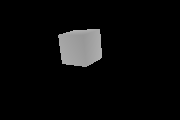

In [63]:
middle_width = 20

temp_viz = Image.new(
        "RGB", (gt_images.shape[2] + middle_width, gt_images.shape[1])
)
temp_viz.paste(
    Image.fromarray(
        np.array(gt_images[testframe, :, :, 2]) / 10.0 * 255.0, mode="F"
    ),
    (0, 0),
)
temp_viz





In [ ]:
# cube corner stuff

In [112]:
cube_corner_plane_poses = jnp.array(
    [
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.5],
            [0.0, 0.0, 0.0, 1.0],
        ], # back
        # [
        #     [1.0, 0.0, 0.0, 0.0],
        #     [0.0, 1.0, 0.0, 0.0],
        #     [0.0, 0.0, 1.0, -0.5],
        #     [0.0, 0.0, 0.0, 1.0],
        # ], # front
        # [
        #     [1.0, 0.0, 0.0, 0.0],
        #     [0.0, 0.0, -1.0, 0.5],
        #     [0.0, 1.0, 0.0, 0.0],
        #     [0.0, 0.0, 0.0, 1.0],
        # ], # bottom
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, -0.5],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        # [
        #     [0.0, 0.0, 1.0, 0.5],
        #     [0.0, 1.0, 0.0, 0.0],
        #     [-1.0, 0.0, 0.0, 0.0],
        #     [0.0, 0.0, 0.0, 1.0],
        # ],
        [
            [0.0, 0.0, 1.0, -0.5],
            [0.0, 1.0, 0.0, 0.0],
            [-1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
    ]
)

corner_plane_dimensions = jnp.array(
    [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]#, [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]
) 
corner_shape = (cube_corner_plane_poses, corner_plane_dimensions)
print(cube_corner_plane_poses.shape)

corner_image = render_planes_lambda_jit(gt_poses[10], corner_shape)


(3, 4, 4)


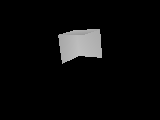

In [113]:

corner_viz = Image.new(
        "RGB", (corner_image.shape[1], corner_image.shape[0])
)
corner_viz.paste(
    Image.fromarray(
        np.array(corner_image[:, :, 2]) / 10.0 * 255.0, mode="F"
    ),
    (0, 0),
)
corner_viz



In [105]:
from scipy import ndimage as ndi
import numpy as np

imggray = gt_images[testframe, :, :, 2] / 10.0 * 255.0

@jax.jit
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = jnp.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return jax.scipy.signal.convolve2d(imggray, kernel_x, mode='same')

@jax.jit
def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return jax.scipy.signal.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(imggray)
I_y = gradient_y(imggray) 

Ixx = ndi.gaussian_filter(I_x**2, sigma=1)
Ixy = ndi.gaussian_filter(I_y*I_x, sigma=1)
Iyy = ndi.gaussian_filter(I_y**2, sigma=1)


In [60]:
k = 0.06

# determinant
detA = Ixx * Iyy - Ixy ** 2
# trace
traceA = Ixx + Iyy
    
harris_response = detA - k * traceA ** 2  # compute harris response in det-trace space

In [61]:
smalleps = 1e-3
rr, cr = range(h), range(w)

from PIL import ImageDraw
draw = ImageDraw.Draw(temp_viz)

cnt = 0
x = []
max_sofar = float('-inf')
# jax todo: practice optimizing this
for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            cnt += 1
            if r > max_sofar:
                max_sofar = r
                max_r, max_c = rowindex, colindex
                draw.ellipse([max_c-smalleps, max_r-smalleps, 
                    max_c + smalleps, max_r + smalleps], fill='red')
                print(".")
            # this is a corner
            # draw.ellipse([colindex-smalleps, rowindex-smalleps, 
            #             colindex + smalleps, rowindex + smalleps], fill='blue')
            temp_viz
draw.ellipse([max_c-smalleps, max_r-smalleps, 
            max_c + smalleps, max_r + smalleps], fill='red')

cnt

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


399

In [ ]:
where(harris_response > 0)

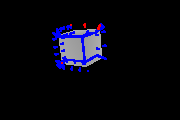

In [62]:
temp_viz

In [ ]:
# get coordinate image template and do 2d icp

# ICP on 2d patch? 

# at each pixel compute distances to all neighbors, take argmin, then store 3d coordinate of the argmin neighbor
# and ultimately get NN of each point
# will be fast because no kdtree yay 

In [ ]:
# render GT images from gt poses

def render_planes_lambda(pose, shape):
    return render_planes(pose, shape, h, w, fx_fy, cx_cy)


render_planes_lambda_jit = jax.jit(render_planes_lambda)

key = jax.random.PRNGKey(3)

gt_images = jnp.stack([render_planes_lambda_jit(p, shape) for p in gt_poses])
print(gt_images.shape)
print((gt_images[0, :, :, -1] > 0).sum()); print((gt_images[0, :, :, 0] != 0).sum())

In [28]:
# define scorer 
scorer = make_scoring_function(shape, h, w, fx_fy, cx_cy, r, outlier_prob)
score = scorer(key, gt_poses[0], gt_images[0, :, :, :])

scorer_parallel = jax.vmap(scorer, in_axes=(0, 0, None))

In [29]:
# create pose deltas to be used for proposals

key, *sub_keys = jax.random.split(key, 15)

def f(key):
    key, (_, v) = genjax.VonMisesFisher.random_weighted(
        key, jnp.array([1.0, 0.0, 0.0, 0.0]), float('inf')  # rand sample rotation
    )
    return quaternion_to_rotation_matrix(v)

rotation_deltas = [f(sub_key) for sub_key in sub_keys]
grid = make_centered_grid_enumeration_3d_points(0.2, 0.2, 0.2, 4, 4, 4)
pose_deltas = [
    jnp.vstack(
        [jnp.hstack([R, t.reshape(3, 1)]), jnp.array([0.0, 0.0, 0.0, 1.0])]
    )
    for R in rotation_deltas
    for t in grid
]


pose_deltas = jnp.stack(pose_deltas)

In [30]:
print("grid ", pose_deltas.shape)
key, *sub_keys = jax.random.split(key, pose_deltas.shape[0] + 1)
sub_keys = jnp.array(sub_keys)

grid  (896, 4, 4)


In [31]:
def _inner(x, gt_image):
    for _ in range(1):
        proposals = jnp.einsum("ij,ajk->aik", x, pose_deltas)  # proposed poses by applying pose deltas
        _, weights_new, x = scorer_parallel(sub_keys, proposals, gt_image)
        x = proposals[jnp.argmax(weights_new)]  # return highest pose proposal
    return x, x


def inference(init_pos, gt_images):
    return jax.lax.scan(_inner, init_pos, gt_images)


inference_jit = jax.jit(inference)
a = inference_jit(gt_poses[0], gt_images)

In [32]:
start = time.time()
_, inferred_poses = inference_jit(gt_poses[0], gt_images)
end = time.time()
elapsed = end - start
print("Time elapsed:", elapsed)
print("FPS:", gt_images.shape[0] / elapsed)

Time elapsed: 3.7326395511627197
FPS: 13.663253389712775


In [29]:
images = []
middle_width = 20
for i in range(gt_images.shape[0]):
    dst = Image.new(
        "RGB", (2 * gt_images.shape[2] + middle_width, gt_images.shape[1])
    )
    dst.paste(
        Image.fromarray(
            np.array(gt_images[i, :, :, 2]) / 10.0 * 255.0, mode="F"
        ),
        (0, 0),
    )

    dst.paste(
        Image.new("RGB", (middle_width, gt_images.shape[1]), (255, 255, 255)),
        (gt_images.shape[2], 0),
    )

    pose = inferred_poses[i]
    rendered_image = render_planes_lambda_jit(pose, shape)
    dst.paste(
        Image.fromarray(
            np.array(rendered_image[:, :, 2]) / 10.0 * 255.0, mode="F"
        ),
        (gt_images.shape[2] + middle_width, 0),
    )
    images.append(dst)

In [30]:
images[0].save(
    fp="out_kerm.gif",
    format="GIF",
    append_images=images,
    save_all=True,
    duration=100,
    loop=0,
)